In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt

In [2]:
def parse_wf_from_binary(filename):
    data_list = []
    nlines=0
    nevents=2000
    with open(filename, "rb") as f:
        while True:
            # Read the header                                                                                                                                                                                                                    
            data = f.read(4)  # Read uint32_t EVID                                                                                                                                                                                               
            if not data:
                break
            EVID = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t T                                                                                                                                                                                                  
            if not data:
                break
            T = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t size                                                                                                                                                                                               
            if not data:
                break
            size = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t sampl_time                                                                                                                                                                                         
            if not data:
                break
            sampl_time = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t ch (number of channels)                                                                                                                                                                            
            if not data:
                break
            ch = struct.unpack("<I", data)[0]
            waveform_data = {}
            # Read waveforms for each channel                                                                                                                                                                                                    
            for channel in range(ch):
                data = f.read(2)  # Read uint16_t numch                                                                                                                                                                                          
                if not data:
                    break
                numch = struct.unpack("<H", data)[0]
                channel_waveforms = []
                for _ in range(size):
                    data = f.read(4)  # Read float w                                                                                                                                                                                             
                    if not data:
                        break
                    w = struct.unpack("<f", data)[0]
                    channel_waveforms.append(w)
                waveform_data[f'{numch}'] = channel_waveforms
            # Create a row per sample point with all channels aligned                                                                                                                                                                            
            for i in range(size):
                row = {}

                row.update({f'CH{j+1}': waveform_data[f'{numch}'][i]/1e3 for j,numch in enumerate(waveform_data)})
                row.update({"event": EVID})
                row.update({"event_time": T})

                data_list.append(row)

    print(nlines,nevents)
    df = pd.DataFrame(data_list)
    df.insert(0, 'TIME', (df.index % size + 1) * sampl_time/1e9)  # Time in microseconds                                                                                                                                                         
    return df


In [3]:
run_dir = "/data/marian/cigar/runs/20251015_Xe_no_source_17deg_54.5V_Autotrg"
df = parse_wf_from_binary(f"{run_dir}/Acq_dig2-192.168.0.254_20251015162411-05.bin")

0 2000


In [6]:
# Filter for a specific event (change index as needed)
event_list = df['event'].unique()
df_event = df[df['event'] == event_list[6]]  # Change the index to choose different event


In [13]:
channels = ['CH2', 'CH3', 'CH4', 'CH5']

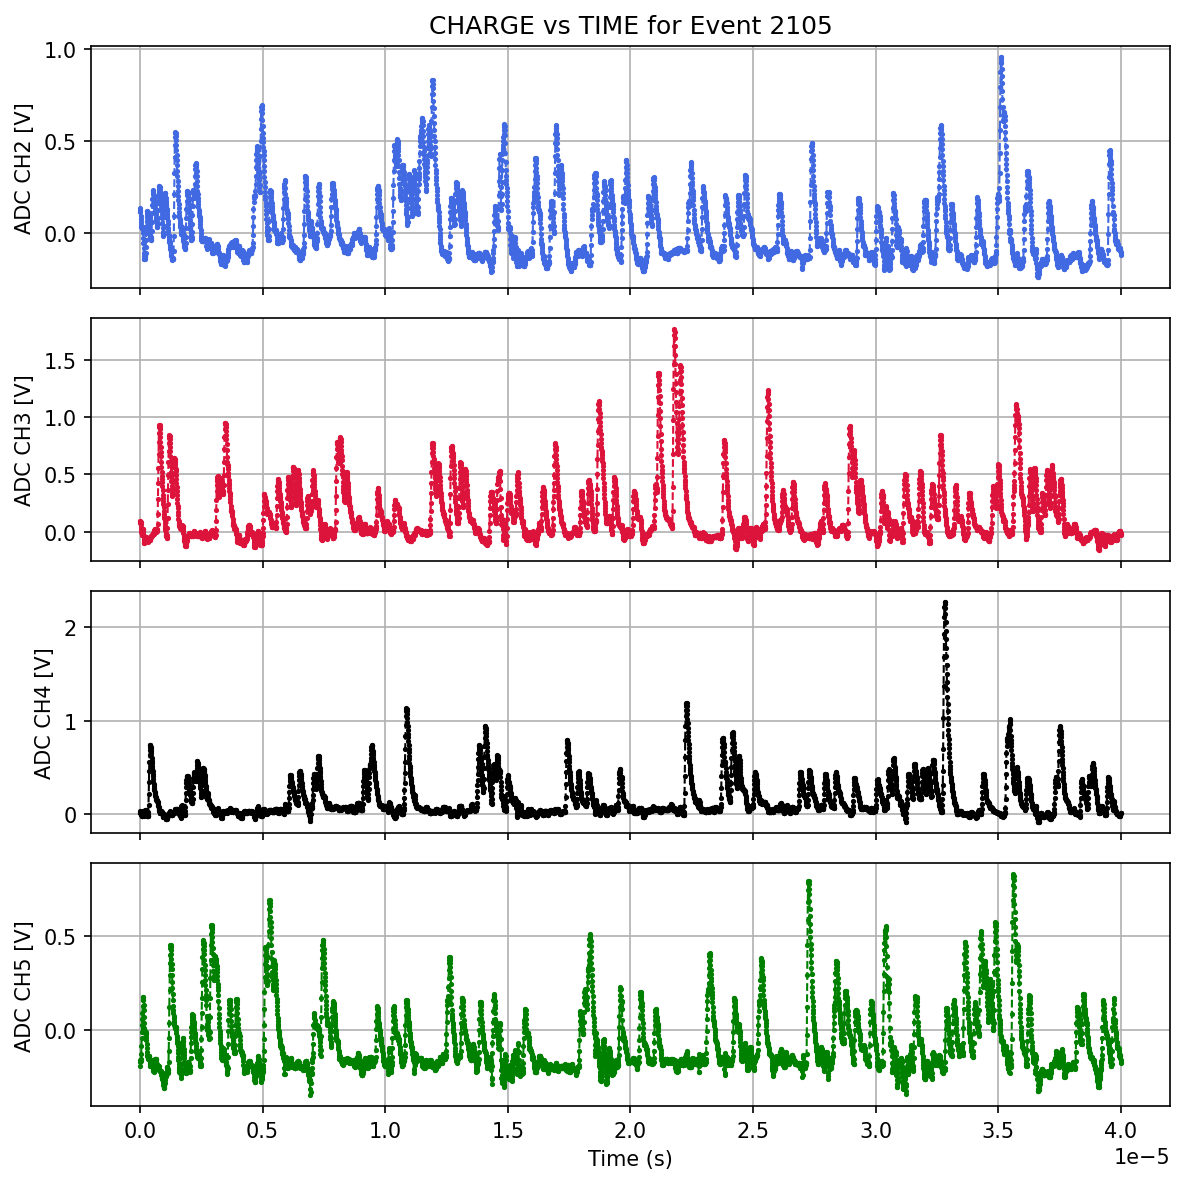

In [18]:
# Create subplots: 2 rows, 1 column
fig, axs = plt.subplots(4, 1, figsize=(8, 8), dpi=150, sharex=True)
colors = ['royalblue', 'crimson', 'black', 'green']

axs[0].set_title(f'CHARGE vs TIME for Event {event_list[5]}')

# Plot CHs
for i in range(4):
    axs[i].plot(df_event['TIME'], (df_event[f'{channels[i]}']-df_event[df_event['TIME']<2e-7][f'{channels[i]}'].mean()), marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{channels[i]}')
    axs[i].set_ylabel(f'ADC {channels[i]} [V]')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()